## Vesuvius Challenge - Ink Detection Training Notebook

### Setup

In [1]:
# # Pretrained weights
# # ref - https://github.com/kenshohara/3D-ResNets-PyTorch
# !pip install gdown
# !gdown 1Nb4abvIkkp_ydPFA9sNPT1WakoVKA8Fa

# # Utility packages for reading and visualizing volumes
# !pip install zarr imageio-ffmpeg

# save model checkpoints
!mkdir ./ckpts

mkdir: cannot create directory ‘./ckpts’: File exists


In [2]:
import os
import gc
import sys
import zarr
import random
import imageio
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Video

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader

sys.path.append("./resnet3d")
from resnet3d import generate_model

### Config

In [3]:
LR = 1e-4
EPOCHS = 50
BATCH_SIZE = 20
CROP_SIZE = 384
Z_START = 24
Z_DIMS = 16
TRAIN_FRAGMENTS = ["2", "3"]
TEST_FRAGMENT = "1"

### Load data

In [4]:


FRAGMENTS_ZARR = {
    "1" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-1.zarr", mode="r"),
    "2" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-2.zarr", mode="r"),
    "3" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-3.zarr", mode="r")
}

FRAGMENTS_SHAPE = {k : v.mask.shape for k, v in FRAGMENTS_ZARR.items()}

### Visualise input

In [5]:
fragment = FRAGMENTS_ZARR["1"]
x, y = 2000, 2000

fragment_cropped = fragment.surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, Z_START:Z_START+Z_DIMS]
imageio.mimwrite("fragment_crop.mp4", fragment_cropped.transpose(2, 0, 1), "ffmpeg")
Video("fragment_crop.mp4", height=256, width=256)

Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. C

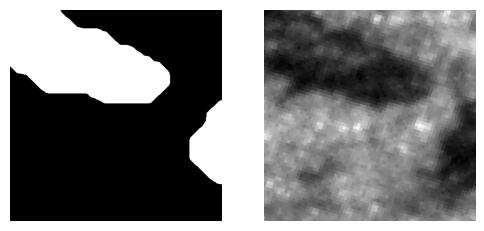

In [6]:
mask_cropped = fragment.truth[y:y+CROP_SIZE, x:x+CROP_SIZE]
ir_cropped = fragment.infrared[y:y+CROP_SIZE, x:x+CROP_SIZE]

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(mask_cropped, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ir_cropped, cmap="gray")
plt.axis("off")
plt.show()

In [7]:
del fragment, fragment_cropped, mask_cropped, ir_cropped
gc.collect()

4093

### Dataloaders

In [8]:
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# class VesuviusTrain(Dataset):
#     def __init__(self, fragments):
#         self.fragments = fragments
#         self.xys = []
        
#         for fragment in fragments:
#             H, W = FRAGMENTS_SHAPE[fragment]
#             for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
#                 for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
#                     self.xys.append((fragment, x, y, W, H))
        
#         train_aug_list = [
#                 # A.RandomResizedCrop(
#                 #     size, size, scale=(0.85, 1.0)),
#                 A.HorizontalFlip(p=0.5),
#                 A.VerticalFlip(p=0.5),
#                 A.RandomBrightnessContrast(p=0.75),
#                 A.CoarseDropout(max_holes=1, max_width=int(CROP_SIZE * 0.1), max_height=int(size * 0.1), 
#                                 mask_fill_value=0, p=0.5),
#                 A.ShiftScaleRotate(p=0.75),
#                 A.Rotate(limit=90, p=0.9), 
#                 A.OneOf([
#                         A.GaussNoise(var_limit=[10, 50]),
#                         A.GaussianBlur(),
#                         A.MotionBlur(),
#                         ], p=0.4),
#                 A.GridDistortion(num_steps=1, distort_limit=0.3, p=0.5),
                
#                 A.Cutout(max_h_size=int(size * 0.6),
#                          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
#                 A.Normalize(
#                     mean= [0] * Z_DIMS,
#                     std= [1] * Z_DIMS
#                 ),
#                 ToTensorV2(transpose_mask=True),
#             ]
        
        
        
#     def __getitem__(self, i):
#         fragment, x1, y1, W, H = self.xys[i]
#         z1, z2 = Z_START, Z_START+Z_DIMS
        
#         x_offset = random.randint(-32 if x1 != 0 else 0, 32)
#         y_offset = random.randint(-32 if y1 != 0 else 0, 32)
        
#         x1 += x_offset
#         y1 += y_offset
        
#         x2 = x1 + CROP_SIZE
#         y2 = y1 + CROP_SIZE
        
#         if x2 > W:
#             x1 -= x_offset
#             x2 -= x_offset
            
#         if y2 > H:
#             y1 -= y_offset
#             y2 -= y_offset
        
#         frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
#         mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
#         if random.random() > 0.5:
#             frag_crop = np.flip(frag_crop, axis=1).copy()
#             mask_crop = np.flip(mask_crop, axis=1).copy()

#         frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
#         frag_crop = frag_crop/65535.0
#         frag_crop = (frag_crop - 0.45)/0.225
        
#         mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        
        
        
        
        
        
        
        
#         return frag_crop, mask_crop

#     def __len__(self):
#         return len(self.xys)

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class VesuviusTrain(Dataset):
    def __init__(self, fragments):
        self.fragments = fragments
        self.xys = []
        
        for fragment in fragments:
            H, W = FRAGMENTS_SHAPE[fragment]
            for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
                for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                    surface = FRAGMENTS_ZARR[fragment].surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, 0]
                    if np.sum(surface) / (CROP_SIZE * CROP_SIZE) > 0.2:
                        self.xys.append((fragment, x, y, W, H))
        
        self.train_aug_list = [
                # A.RandomResizedCrop(
                #     size, size, scale=(0.85, 1.0)),
                
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                
                # A.RandomBrightnessContrast(p=0.75),
                # A.CoarseDropout(max_holes=1, max_width=int(CROP_SIZE * 0.1), max_height=int(CROP_SIZE * 0.1), 
                #                 mask_fill_value=0, p=0.5),
                # A.ShiftScaleRotate(p=0.75),
                
                A.Rotate(limit=90, p=0.9), 
                
                # A.OneOf([
                #         A.GaussNoise(var_limit=[1, 5]),
                #         A.GaussianBlur(),
                #         A.MotionBlur(),
                #         ], p=0.4),
                # A.GridDistortion(num_steps=1, distort_limit=0.3, p=0.5),
                
                # A.Cutout(max_h_size=int(CROP_SIZE * 0.2),
                #          max_w_size=int(CROP_SIZE * 0.2), num_holes=1, p=1.0),
                # A.Normalize(
                #     mean= [0] * Z_DIMS,
                #     std= [1] * Z_DIMS
                # ),
                
                
                ToTensorV2(transpose_mask=True),
            ]
        
        # Create the augmentation pipeline
        self.augmentations = A.Compose(self.train_aug_list)
        
        
        
    def __getitem__(self, i):
        fragment, x1, y1, W, H = self.xys[i]
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        x_offset = random.randint(-192 if x1 != 0 else 0, 192)
        y_offset = random.randint(-192 if y1 != 0 else 0, 192)
        
        x1 += x_offset
        y1 += y_offset
        
        x2 = x1 + CROP_SIZE
        y2 = y1 + CROP_SIZE
        
        if x2 > W:
            x1 -= x_offset
            x2 -= x_offset
            
        if y2 > H:
            y1 -= y_offset
            y2 -= y_offset
        
        frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
        # if random.random() > 0.5:
        #     frag_crop = np.flip(frag_crop, axis=1).copy()
        #     mask_crop = np.flip(mask_crop, axis=1).copy()

        # Perform train augmentations

        frag_crop = frag_crop/65535.0
        

        # Apply the augmentations
        augmented = self.augmentations(image=frag_crop, mask=mask_crop)

        # Separate the image and mask
        frag_crop, mask_crop = augmented["image"], augmented["mask"]

        # normalize
        
        # frag_crop = (frag_crop - 0.45)/0.225
        
        frag_crop = frag_crop.unsqueeze(0)
        mask_crop = mask_crop.float().unsqueeze(0)
        
        
        return frag_crop, mask_crop

    def __len__(self):
        return len(self.xys)

In [10]:
class VesuviusVal(Dataset):
    def __init__(self, fragment):
        self.fragment = FRAGMENTS_ZARR[fragment]
        self.xys = []
        
        H, W = FRAGMENTS_SHAPE[fragment]
        for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
            for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                self.xys.append((x, y))
                
    def __getitem__(self, i):
        x1, y1 = self.xys[i]
        x2, y2 = x1+CROP_SIZE, y1+CROP_SIZE
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        frag_crop = self.fragment.surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = self.fragment.truth[y1:y2, x1:x2]

        frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
        frag_crop = frag_crop/65535.0
        # frag_crop = (frag_crop - 0.45)/0.225
        
        mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        return frag_crop, mask_crop, torch.tensor([x1, y1, x2, y2], dtype=torch.int32)

    def __len__(self):
        return len(self.xys)

In [11]:
dataset_train = VesuviusTrain(TRAIN_FRAGMENTS)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=True, pin_memory=True, drop_last=True)
n_train = len(dataloader_train)

dataset_valid = VesuviusVal(TEST_FRAGMENT)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=False, pin_memory=True, drop_last=False)
n_valid = len(dataloader_valid)

In [12]:
i = random.randint(0, len(dataset_train))
img = dataset_train[i][0]
img.min(), img.max()

(tensor(0., dtype=torch.float64), tensor(1., dtype=torch.float64))

### Model
* Encoder is a 3D ResNet model. The architecture has been modified to remove temporal downsampling between blocks.
* A 2D decoder is used for predicting the segmentation map.
* The encoder feature maps are average pooled over the Z dimension before passing it to the decoder.

In [13]:
class Decoder(nn.Module):
    def __init__(self, encoder_dims, upscale):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dims[i]+encoder_dims[i-1], encoder_dims[i-1], 3, 1, 1, bias=False),
                nn.BatchNorm2d(encoder_dims[i-1]),
                nn.ReLU(inplace=True)
            ) for i in range(1, len(encoder_dims))])

        self.logit = nn.Conv2d(encoder_dims[0], 1, 1, 1, 0)
        self.up = nn.Upsample(scale_factor=upscale, mode="bilinear")

    def forward(self, feature_maps):
        for i in range(len(feature_maps)-1, 0, -1):
            f_up = F.interpolate(feature_maps[i], scale_factor=2, mode="bilinear")
            f = torch.cat([feature_maps[i-1], f_up], dim=1)
            f_down = self.convs[i-1](f)
            feature_maps[i-1] = f_down

        x = self.logit(feature_maps[0])
        mask = self.up(x)
        return mask


class SegModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = generate_model(model_depth=18, n_input_channels=1)
        self.decoder = Decoder(encoder_dims=[64, 128, 256, 512], upscale=4)
        
    def forward(self, x):
        feat_maps = self.encoder(x)
        feat_maps_pooled = [torch.mean(f, dim=2) for f in feat_maps]
        pred_mask = self.decoder(feat_maps_pooled)
        return pred_mask
    
    def load_pretrained_weights(self, state_dict):
        # Convert 3 channel weights to single channel
        # ref - https://timm.fast.ai/models#Case-1:-When-the-number-of-input-channels-is-1
        conv1_weight = state_dict['conv1.weight']
        state_dict['conv1.weight'] = conv1_weight.sum(dim=1, keepdim=True)
        print(self.encoder.load_state_dict(state_dict, strict=False))

In [14]:
model = SegModel()
model.load_pretrained_weights(torch.load("/home/viktor/Documents/kaggle/vesuvius-challenge/experiments/3D-resnet/r3d18_K_200ep.pth")["state_dict"])
model = nn.DataParallel(model, device_ids=[0])

model = model.cuda()

_IncompatibleKeys(missing_keys=[], unexpected_keys=['fc.weight', 'fc.bias'])


In [15]:
x = torch.randn(5, 1, 16, 256, 256).cuda()
with torch.no_grad():
    y = model(x)
y.shape

torch.Size([5, 1, 256, 256])

### Competition metric (F0.5 Score)

In [16]:
# ref - https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
def fbeta_score(preds, targets, threshold, beta=0.5, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = targets.sum()
    
    ctp = preds_t[targets==1].sum()
    cfp = preds_t[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

### Training

In [17]:
scaler = amp.GradScaler()
# criterion = nn.BCEWithLogitsLoss()


optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
                                                steps_per_epoch=10, epochs=EPOCHS//10,
                                                pct_start=0.1)

In [18]:
import segmentation_models_pytorch as smp
DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()


def criterion(y_pred, y_true):
    return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)

In [19]:
gt_mask = torch.from_numpy(np.asarray(FRAGMENTS_ZARR[TEST_FRAGMENT].truth)).float().cuda()
gt_shape = FRAGMENTS_SHAPE[TEST_FRAGMENT]

In [20]:
import logging

logging.basicConfig(filename="training_log.txt", level=logging.INFO)


In [21]:
fbeta_best = 0.0
for epoch in range(1, EPOCHS+1):
    model.train()
    cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

    




    for i, (fragments, masks) in pbar_train:
        fragments, masks = fragments.cuda().half(), masks.cuda().half()
        
        
        optimizer.zero_grad()
        with amp.autocast():
            pred_masks = model(fragments)
            loss = criterion(pred_masks, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            mloss_train += loss.detach().item()

        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
                                                              f"Loss: {mloss_train / (i + 1):.4f}"))
        
    scheduler.step()
    model.eval()
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
    for i, (fragments, masks, xys) in pbar_val:
        fragments, masks = fragments.cuda(), masks.cuda()
        
        with torch.no_grad():
            pred_masks = model(fragments)
            mloss_val += criterion(pred_masks, masks).item()
            pred_masks = torch.sigmoid(pred_masks)
        
        for j, xy in enumerate(xys):
            final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

        pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
    
    for threshold in np.arange(0.2, 0.85, 0.05):
        fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
        print(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")
        
        if fbeta_best < fbeta:
            fbeta_best = fbeta
            torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_best_{fbeta_best:.4f}.pt")
    
    
    # if epoch >= 10:
    #     torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_epoch_{epoch}.pt")

    # if epoch == 30:
    #     break

    print()

Epoch 1/50  Mem : 19.6GB  LR : 4.00E-06  Loss: 0.6703: 100%|██████████| 44/44 [00:30<00:00,  1.43it/s]                                                                                                                                                            
Val Loss: 0.6185: 100%|██████████| 17/17 [00:05<00:00,  3.10it/s]                                                                                                                                                                                                 


Threshold : 0.20	FBeta : 0.162402
Threshold : 0.25	FBeta : 0.209348
Threshold : 0.30	FBeta : 0.227892
Threshold : 0.35	FBeta : 0.242407
Threshold : 0.40	FBeta : 0.255850
Threshold : 0.45	FBeta : 0.242488
Threshold : 0.50	FBeta : 0.127058
Threshold : 0.55	FBeta : 0.020451
Threshold : 0.60	FBeta : 0.002706
Threshold : 0.65	FBeta : 0.000556
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 2/50  Mem : 14.1GB  LR : 1.81E-05  Loss: 0.6497: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]                                                                                                                                                            
Val Loss: 0.5853: 100%|██████████| 17/17 [00:05<00:00,  3.04it/s]                                                                                                                                                                                                 


Threshold : 0.20	FBeta : 0.229461
Threshold : 0.25	FBeta : 0.238301
Threshold : 0.30	FBeta : 0.248666
Threshold : 0.35	FBeta : 0.263026
Threshold : 0.40	FBeta : 0.275203
Threshold : 0.45	FBeta : 0.286150
Threshold : 0.50	FBeta : 0.284768
Threshold : 0.55	FBeta : 0.262700
Threshold : 0.60	FBeta : 0.218299
Threshold : 0.65	FBeta : 0.147598
Threshold : 0.70	FBeta : 0.084885
Threshold : 0.75	FBeta : 0.026113
Threshold : 0.80	FBeta : 0.001916



Epoch 3/50  Mem : 14.1GB  LR : 5.20E-05  Loss: 0.6171: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]                                                                                                                                                            
Val Loss: 0.6720: 100%|██████████| 17/17 [00:05<00:00,  3.02it/s]                                                                                                                                                                                                 


Threshold : 0.20	FBeta : 0.153972
Threshold : 0.25	FBeta : 0.164902
Threshold : 0.30	FBeta : 0.178145
Threshold : 0.35	FBeta : 0.197855
Threshold : 0.40	FBeta : 0.234105
Threshold : 0.45	FBeta : 0.299058
Threshold : 0.50	FBeta : 0.326193
Threshold : 0.55	FBeta : 0.338938
Threshold : 0.60	FBeta : 0.351912
Threshold : 0.65	FBeta : 0.364337
Threshold : 0.70	FBeta : 0.374417
Threshold : 0.75	FBeta : 0.379077
Threshold : 0.80	FBeta : 0.376791



Epoch 4/50  Mem : 14.1GB  LR : 8.59E-05  Loss: 0.5980: 100%|██████████| 44/44 [00:31<00:00,  1.42it/s]                                                                                                                                                            
Val Loss: 0.6038: 100%|██████████| 17/17 [00:05<00:00,  3.09it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.157248
Threshold : 0.25	FBeta : 0.021193
Threshold : 0.30	FBeta : 0.000553
Threshold : 0.35	FBeta : 0.000000
Threshold : 0.40	FBeta : 0.000000
Threshold : 0.45	FBeta : 0.000000
Threshold : 0.50	FBeta : 0.000000
Threshold : 0.55	FBeta : 0.000000
Threshold : 0.60	FBeta : 0.000000
Threshold : 0.65	FBeta : 0.000000
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000




Epoch 5/50  Mem : 14.1GB  LR : 1.00E-04  Loss: 0.5677: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]                                                                                                                                                            
Val Loss: 0.5336: 100%|██████████| 17/17 [00:05<00:00,  3.09it/s]                                                                                                                                                                                                 


Threshold : 0.20	FBeta : 0.256570
Threshold : 0.25	FBeta : 0.283489
Threshold : 0.30	FBeta : 0.306534
Threshold : 0.35	FBeta : 0.328452
Threshold : 0.40	FBeta : 0.347995
Threshold : 0.45	FBeta : 0.365169
Threshold : 0.50	FBeta : 0.384884
Threshold : 0.55	FBeta : 0.405017
Threshold : 0.60	FBeta : 0.421410
Threshold : 0.65	FBeta : 0.430315
Threshold : 0.70	FBeta : 0.433346
Threshold : 0.75	FBeta : 0.425427
Threshold : 0.80	FBeta : 0.402538



Epoch 6/50  Mem : 14.1GB  LR : 9.99E-05  Loss: 0.5343: 100%|██████████| 44/44 [00:30<00:00,  1.42it/s]                                                                                                                                                            
Val Loss: 0.5973: 100%|██████████| 17/17 [00:05<00:00,  3.04it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.197590
Threshold : 0.25	FBeta : 0.124228
Threshold : 0.30	FBeta : 0.093332
Threshold : 0.35	FBeta : 0.075455
Threshold : 0.40	FBeta : 0.061224
Threshold : 0.45	FBeta : 0.047571
Threshold : 0.50	FBeta : 0.035717
Threshold : 0.55	FBeta : 0.025741
Threshold : 0.60	FBeta : 0.016749
Threshold : 0.65	FBeta : 0.008905
Threshold : 0.70	FBeta : 0.003683
Threshold : 0.75	FBeta : 0.001058
Threshold : 0.80	FBeta : 0.000000




Epoch 7/50  Mem : 14.1GB  LR : 9.95E-05  Loss: 0.5189: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]                                                                                                                                                            
Val Loss: 0.5933: 100%|██████████| 17/17 [00:05<00:00,  3.06it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.264257
Threshold : 0.25	FBeta : 0.239849
Threshold : 0.30	FBeta : 0.218258
Threshold : 0.35	FBeta : 0.200843
Threshold : 0.40	FBeta : 0.181401
Threshold : 0.45	FBeta : 0.164284
Threshold : 0.50	FBeta : 0.143437
Threshold : 0.55	FBeta : 0.113047
Threshold : 0.60	FBeta : 0.078576
Threshold : 0.65	FBeta : 0.056125
Threshold : 0.70	FBeta : 0.040070
Threshold : 0.75	FBeta : 0.024747
Threshold : 0.80	FBeta : 0.011196




Epoch 8/50  Mem : 14.1GB  LR : 9.89E-05  Loss: 0.5041: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]                                                                                                                                                            
Val Loss: 0.5864: 100%|██████████| 17/17 [00:05<00:00,  3.07it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.322183
Threshold : 0.25	FBeta : 0.274597
Threshold : 0.30	FBeta : 0.241644
Threshold : 0.35	FBeta : 0.217264
Threshold : 0.40	FBeta : 0.196138
Threshold : 0.45	FBeta : 0.175881
Threshold : 0.50	FBeta : 0.154548
Threshold : 0.55	FBeta : 0.129982
Threshold : 0.60	FBeta : 0.101447
Threshold : 0.65	FBeta : 0.069621
Threshold : 0.70	FBeta : 0.043926
Threshold : 0.75	FBeta : 0.029490
Threshold : 0.80	FBeta : 0.019318




Epoch 9/50  Mem : 14.1GB  LR : 9.81E-05  Loss: 0.4938: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]                                                                                                                                                            
Val Loss: 0.5304: 100%|██████████| 17/17 [00:05<00:00,  3.07it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.382397
Threshold : 0.25	FBeta : 0.390163
Threshold : 0.30	FBeta : 0.393912
Threshold : 0.35	FBeta : 0.391018
Threshold : 0.40	FBeta : 0.385666
Threshold : 0.45	FBeta : 0.375340
Threshold : 0.50	FBeta : 0.354359
Threshold : 0.55	FBeta : 0.324876
Threshold : 0.60	FBeta : 0.293454
Threshold : 0.65	FBeta : 0.260503
Threshold : 0.70	FBeta : 0.218689
Threshold : 0.75	FBeta : 0.174195
Threshold : 0.80	FBeta : 0.133901




Epoch 10/50  Mem : 14.1GB  LR : 9.70E-05  Loss: 0.4847: 100%|██████████| 44/44 [00:30<00:00,  1.42it/s]                                                                                                                                                           
Val Loss: 0.5044: 100%|██████████| 17/17 [00:05<00:00,  3.04it/s]                                                                                                                                                                                                 


Threshold : 0.20	FBeta : 0.343677
Threshold : 0.25	FBeta : 0.358939
Threshold : 0.30	FBeta : 0.369985
Threshold : 0.35	FBeta : 0.378969
Threshold : 0.40	FBeta : 0.387401
Threshold : 0.45	FBeta : 0.396010
Threshold : 0.50	FBeta : 0.406918
Threshold : 0.55	FBeta : 0.422395
Threshold : 0.60	FBeta : 0.435212
Threshold : 0.65	FBeta : 0.445713
Threshold : 0.70	FBeta : 0.453479
Threshold : 0.75	FBeta : 0.462214
Threshold : 0.80	FBeta : 0.467903



Epoch 11/50  Mem : 14.1GB  LR : 9.57E-05  Loss: 0.4614: 100%|██████████| 44/44 [00:30<00:00,  1.43it/s]                                                                                                                                                           
Val Loss: 0.4921: 100%|██████████| 17/17 [00:05<00:00,  3.06it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.399288
Threshold : 0.25	FBeta : 0.417849
Threshold : 0.30	FBeta : 0.433649
Threshold : 0.35	FBeta : 0.443490
Threshold : 0.40	FBeta : 0.451343
Threshold : 0.45	FBeta : 0.457724
Threshold : 0.50	FBeta : 0.460131
Threshold : 0.55	FBeta : 0.460712
Threshold : 0.60	FBeta : 0.456225
Threshold : 0.65	FBeta : 0.447600
Threshold : 0.70	FBeta : 0.431581
Threshold : 0.75	FBeta : 0.406031
Threshold : 0.80	FBeta : 0.376204




Epoch 12/50  Mem : 14.1GB  LR : 9.41E-05  Loss: 0.4579: 100%|██████████| 44/44 [00:30<00:00,  1.42it/s]                                                                                                                                                           
Val Loss: 0.5738: 100%|██████████| 17/17 [00:05<00:00,  3.08it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.335093
Threshold : 0.25	FBeta : 0.282845
Threshold : 0.30	FBeta : 0.244032
Threshold : 0.35	FBeta : 0.210827
Threshold : 0.40	FBeta : 0.180212
Threshold : 0.45	FBeta : 0.150559
Threshold : 0.50	FBeta : 0.128250
Threshold : 0.55	FBeta : 0.109577
Threshold : 0.60	FBeta : 0.095624
Threshold : 0.65	FBeta : 0.080235
Threshold : 0.70	FBeta : 0.065781
Threshold : 0.75	FBeta : 0.050672
Threshold : 0.80	FBeta : 0.034354




Epoch 13/50  Mem : 14.1GB  LR : 9.24E-05  Loss: 0.4561: 100%|██████████| 44/44 [00:30<00:00,  1.43it/s]                                                                                                                                                           
Val Loss: 0.5365: 100%|██████████| 17/17 [00:05<00:00,  3.07it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.422548
Threshold : 0.25	FBeta : 0.419298
Threshold : 0.30	FBeta : 0.411362
Threshold : 0.35	FBeta : 0.399797
Threshold : 0.40	FBeta : 0.386054
Threshold : 0.45	FBeta : 0.370180
Threshold : 0.50	FBeta : 0.346319
Threshold : 0.55	FBeta : 0.322697
Threshold : 0.60	FBeta : 0.290725
Threshold : 0.65	FBeta : 0.259389
Threshold : 0.70	FBeta : 0.227965
Threshold : 0.75	FBeta : 0.193500
Threshold : 0.80	FBeta : 0.154531




Epoch 14/50  Mem : 14.1GB  LR : 9.05E-05  Loss: 0.4396: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]                                                                                                                                                           
Val Loss: 0.4872: 100%|██████████| 17/17 [00:05<00:00,  3.06it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.405733
Threshold : 0.25	FBeta : 0.417290
Threshold : 0.30	FBeta : 0.424964
Threshold : 0.35	FBeta : 0.431504
Threshold : 0.40	FBeta : 0.436323
Threshold : 0.45	FBeta : 0.441249
Threshold : 0.50	FBeta : 0.447360
Threshold : 0.55	FBeta : 0.453255
Threshold : 0.60	FBeta : 0.459305
Threshold : 0.65	FBeta : 0.463125
Threshold : 0.70	FBeta : 0.464709
Threshold : 0.75	FBeta : 0.463444
Threshold : 0.80	FBeta : 0.456272




Epoch 15/50  Mem : 14.1GB  LR : 8.83E-05  Loss: 0.4319: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]                                                                                                                                                           
Val Loss: 0.4812: 100%|██████████| 17/17 [00:05<00:00,  3.07it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.364037
Threshold : 0.25	FBeta : 0.373746
Threshold : 0.30	FBeta : 0.382096
Threshold : 0.35	FBeta : 0.390175
Threshold : 0.40	FBeta : 0.398477
Threshold : 0.45	FBeta : 0.407400
Threshold : 0.50	FBeta : 0.417817
Threshold : 0.55	FBeta : 0.427563
Threshold : 0.60	FBeta : 0.434799
Threshold : 0.65	FBeta : 0.441408
Threshold : 0.70	FBeta : 0.447417
Threshold : 0.75	FBeta : 0.453140
Threshold : 0.80	FBeta : 0.454183




Epoch 16/50  Mem : 14.1GB  LR : 8.60E-05  Loss: 0.4291: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]                                                                                                                                                           
Val Loss: 0.5815: 100%|██████████| 17/17 [00:05<00:00,  3.06it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.394682
Threshold : 0.25	FBeta : 0.376208
Threshold : 0.30	FBeta : 0.363132
Threshold : 0.35	FBeta : 0.351005
Threshold : 0.40	FBeta : 0.337472
Threshold : 0.45	FBeta : 0.322971
Threshold : 0.50	FBeta : 0.308354
Threshold : 0.55	FBeta : 0.292373
Threshold : 0.60	FBeta : 0.271808
Threshold : 0.65	FBeta : 0.244074
Threshold : 0.70	FBeta : 0.211844
Threshold : 0.75	FBeta : 0.182394
Threshold : 0.80	FBeta : 0.153008




Epoch 17/50  Mem : 14.1GB  LR : 8.35E-05  Loss: 0.4182: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]                                                                                                                                                           
Val Loss: 0.8920: 100%|██████████| 17/17 [00:05<00:00,  3.06it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.244027
Threshold : 0.25	FBeta : 0.248178
Threshold : 0.30	FBeta : 0.251481
Threshold : 0.35	FBeta : 0.254610
Threshold : 0.40	FBeta : 0.257799
Threshold : 0.45	FBeta : 0.262066
Threshold : 0.50	FBeta : 0.271071
Threshold : 0.55	FBeta : 0.277135
Threshold : 0.60	FBeta : 0.282951
Threshold : 0.65	FBeta : 0.289020
Threshold : 0.70	FBeta : 0.295286
Threshold : 0.75	FBeta : 0.302439
Threshold : 0.80	FBeta : 0.310691




Epoch 18/50  Mem : 14.1GB  LR : 8.08E-05  Loss: 0.4213: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]                                                                                                                                                           
Val Loss: 0.4723: 100%|██████████| 17/17 [00:05<00:00,  3.03it/s]                                                                                                                                                                                                 


Threshold : 0.20	FBeta : 0.400818
Threshold : 0.25	FBeta : 0.418665
Threshold : 0.30	FBeta : 0.431114
Threshold : 0.35	FBeta : 0.440983
Threshold : 0.40	FBeta : 0.451084
Threshold : 0.45	FBeta : 0.461118
Threshold : 0.50	FBeta : 0.470312
Threshold : 0.55	FBeta : 0.475245
Threshold : 0.60	FBeta : 0.479121
Threshold : 0.65	FBeta : 0.483280
Threshold : 0.70	FBeta : 0.484995
Threshold : 0.75	FBeta : 0.482359
Threshold : 0.80	FBeta : 0.469333



Epoch 19/50  Mem : 14.1GB  LR : 7.80E-05  Loss: 0.4130: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]                                                                                                                                                           
Val Loss: 0.5558: 100%|██████████| 17/17 [00:05<00:00,  3.08it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.322026
Threshold : 0.25	FBeta : 0.329014
Threshold : 0.30	FBeta : 0.334405
Threshold : 0.35	FBeta : 0.338669
Threshold : 0.40	FBeta : 0.343080
Threshold : 0.45	FBeta : 0.349968
Threshold : 0.50	FBeta : 0.358481
Threshold : 0.55	FBeta : 0.364495
Threshold : 0.60	FBeta : 0.370301
Threshold : 0.65	FBeta : 0.375821
Threshold : 0.70	FBeta : 0.381177
Threshold : 0.75	FBeta : 0.386527
Threshold : 0.80	FBeta : 0.392146




Epoch 20/50  Mem : 14.1GB  LR : 7.50E-05  Loss: 0.4111: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]                                                                                                                                                           
Val Loss: 0.5286: 100%|██████████| 17/17 [00:05<00:00,  3.06it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.431784
Threshold : 0.25	FBeta : 0.423671
Threshold : 0.30	FBeta : 0.416631
Threshold : 0.35	FBeta : 0.409785
Threshold : 0.40	FBeta : 0.403157
Threshold : 0.45	FBeta : 0.397099
Threshold : 0.50	FBeta : 0.390877
Threshold : 0.55	FBeta : 0.380255
Threshold : 0.60	FBeta : 0.367127
Threshold : 0.65	FBeta : 0.353006
Threshold : 0.70	FBeta : 0.338126
Threshold : 0.75	FBeta : 0.317989
Threshold : 0.80	FBeta : 0.290903




Epoch 21/50  Mem : 14.1GB  LR : 7.19E-05  Loss: 0.3966: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]                                                                                                                                                           
Val Loss: 0.5205: 100%|██████████| 17/17 [00:05<00:00,  3.08it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.351328
Threshold : 0.25	FBeta : 0.358236
Threshold : 0.30	FBeta : 0.363341
Threshold : 0.35	FBeta : 0.366693
Threshold : 0.40	FBeta : 0.370571
Threshold : 0.45	FBeta : 0.374053
Threshold : 0.50	FBeta : 0.378975
Threshold : 0.55	FBeta : 0.383934
Threshold : 0.60	FBeta : 0.387731
Threshold : 0.65	FBeta : 0.389999
Threshold : 0.70	FBeta : 0.392093
Threshold : 0.75	FBeta : 0.391838
Threshold : 0.80	FBeta : 0.388015




Epoch 22/50  Mem : 14.1GB  LR : 6.87E-05  Loss: 0.4139: 100%|██████████| 44/44 [00:30<00:00,  1.43it/s]                                                                                                                                                           
Val Loss: 0.6023: 100%|██████████| 17/17 [00:05<00:00,  3.10it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.395382
Threshold : 0.25	FBeta : 0.374473
Threshold : 0.30	FBeta : 0.354854
Threshold : 0.35	FBeta : 0.337586
Threshold : 0.40	FBeta : 0.322459
Threshold : 0.45	FBeta : 0.307895
Threshold : 0.50	FBeta : 0.291852
Threshold : 0.55	FBeta : 0.274661
Threshold : 0.60	FBeta : 0.255306
Threshold : 0.65	FBeta : 0.233571
Threshold : 0.70	FBeta : 0.209984
Threshold : 0.75	FBeta : 0.183133
Threshold : 0.80	FBeta : 0.156911




Epoch 23/50  Mem : 14.1GB  LR : 6.55E-05  Loss: 0.3882: 100%|██████████| 44/44 [00:30<00:00,  1.42it/s]                                                                                                                                                           
Val Loss: 0.5970: 100%|██████████| 17/17 [00:05<00:00,  3.05it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.304265
Threshold : 0.25	FBeta : 0.312189
Threshold : 0.30	FBeta : 0.319049
Threshold : 0.35	FBeta : 0.325597
Threshold : 0.40	FBeta : 0.331608
Threshold : 0.45	FBeta : 0.338210
Threshold : 0.50	FBeta : 0.346105
Threshold : 0.55	FBeta : 0.353099
Threshold : 0.60	FBeta : 0.359601
Threshold : 0.65	FBeta : 0.366910
Threshold : 0.70	FBeta : 0.374552
Threshold : 0.75	FBeta : 0.383223
Threshold : 0.80	FBeta : 0.393240




Epoch 24/50  Mem : 14.1GB  LR : 6.21E-05  Loss: 0.3807: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]                                                                                                                                                           
Val Loss: 0.4959: 100%|██████████| 17/17 [00:05<00:00,  3.05it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.462556
Threshold : 0.25	FBeta : 0.467552
Threshold : 0.30	FBeta : 0.469226
Threshold : 0.35	FBeta : 0.468596
Threshold : 0.40	FBeta : 0.467386
Threshold : 0.45	FBeta : 0.466023
Threshold : 0.50	FBeta : 0.465238
Threshold : 0.55	FBeta : 0.462224
Threshold : 0.60	FBeta : 0.457378
Threshold : 0.65	FBeta : 0.451139
Threshold : 0.70	FBeta : 0.443130
Threshold : 0.75	FBeta : 0.432455
Threshold : 0.80	FBeta : 0.415490




Epoch 25/50  Mem : 14.1GB  LR : 5.87E-05  Loss: 0.3766: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]                                                                                                                                                           
Val Loss: 0.4967: 100%|██████████| 17/17 [00:05<00:00,  3.10it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.365434
Threshold : 0.25	FBeta : 0.377514
Threshold : 0.30	FBeta : 0.387868
Threshold : 0.35	FBeta : 0.397017
Threshold : 0.40	FBeta : 0.405174
Threshold : 0.45	FBeta : 0.412875
Threshold : 0.50	FBeta : 0.421018
Threshold : 0.55	FBeta : 0.429580
Threshold : 0.60	FBeta : 0.438441
Threshold : 0.65	FBeta : 0.447745
Threshold : 0.70	FBeta : 0.458036
Threshold : 0.75	FBeta : 0.469817
Threshold : 0.80	FBeta : 0.482245




Epoch 26/50  Mem : 14.1GB  LR : 5.52E-05  Loss: 0.3855: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]                                                                                                                                                           
Val Loss: 0.5751: 100%|██████████| 17/17 [00:05<00:00,  3.05it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.317925
Threshold : 0.25	FBeta : 0.324445
Threshold : 0.30	FBeta : 0.330250
Threshold : 0.35	FBeta : 0.335671
Threshold : 0.40	FBeta : 0.341500
Threshold : 0.45	FBeta : 0.349356
Threshold : 0.50	FBeta : 0.363599
Threshold : 0.55	FBeta : 0.370618
Threshold : 0.60	FBeta : 0.376698
Threshold : 0.65	FBeta : 0.382975
Threshold : 0.70	FBeta : 0.390740
Threshold : 0.75	FBeta : 0.399698
Threshold : 0.80	FBeta : 0.408918




Epoch 27/50  Mem : 14.1GB  LR : 5.17E-05  Loss: 0.3751: 100%|██████████| 44/44 [00:30<00:00,  1.43it/s]                                                                                                                                                           
Val Loss: 0.4378: 100%|██████████| 17/17 [00:05<00:00,  3.08it/s]                                                                                                                                                                                                 


Threshold : 0.20	FBeta : 0.467439
Threshold : 0.25	FBeta : 0.478879
Threshold : 0.30	FBeta : 0.488424
Threshold : 0.35	FBeta : 0.496877
Threshold : 0.40	FBeta : 0.504134
Threshold : 0.45	FBeta : 0.511309
Threshold : 0.50	FBeta : 0.517596
Threshold : 0.55	FBeta : 0.521549
Threshold : 0.60	FBeta : 0.525754
Threshold : 0.65	FBeta : 0.529621
Threshold : 0.70	FBeta : 0.532214
Threshold : 0.75	FBeta : 0.534472
Threshold : 0.80	FBeta : 0.532513



Epoch 28/50  Mem : 14.1GB  LR : 4.83E-05  Loss: 0.3661: 100%|██████████| 44/44 [00:31<00:00,  1.41it/s]                                                                                                                                                           
Val Loss: 0.4673: 100%|██████████| 17/17 [00:05<00:00,  3.08it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.411371
Threshold : 0.25	FBeta : 0.422886
Threshold : 0.30	FBeta : 0.431299
Threshold : 0.35	FBeta : 0.437424
Threshold : 0.40	FBeta : 0.442563
Threshold : 0.45	FBeta : 0.447583
Threshold : 0.50	FBeta : 0.451987
Threshold : 0.55	FBeta : 0.456516
Threshold : 0.60	FBeta : 0.461249
Threshold : 0.65	FBeta : 0.465599
Threshold : 0.70	FBeta : 0.469857
Threshold : 0.75	FBeta : 0.472636
Threshold : 0.80	FBeta : 0.473938




Epoch 29/50  Mem : 14.1GB  LR : 4.48E-05  Loss: 0.3704: 100%|██████████| 44/44 [00:30<00:00,  1.43it/s]                                                                                                                                                           
Val Loss: 0.4750: 100%|██████████| 17/17 [00:05<00:00,  3.07it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.374627
Threshold : 0.25	FBeta : 0.388046
Threshold : 0.30	FBeta : 0.399045
Threshold : 0.35	FBeta : 0.408085
Threshold : 0.40	FBeta : 0.416296
Threshold : 0.45	FBeta : 0.424295
Threshold : 0.50	FBeta : 0.431974
Threshold : 0.55	FBeta : 0.439824
Threshold : 0.60	FBeta : 0.448529
Threshold : 0.65	FBeta : 0.458255
Threshold : 0.70	FBeta : 0.469068
Threshold : 0.75	FBeta : 0.480326
Threshold : 0.80	FBeta : 0.493317




Epoch 30/50  Mem : 14.1GB  LR : 4.13E-05  Loss: 0.3627: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]                                                                                                                                                           
Val Loss: 0.4618: 100%|██████████| 17/17 [00:05<00:00,  3.04it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.422081
Threshold : 0.25	FBeta : 0.430910
Threshold : 0.30	FBeta : 0.437915
Threshold : 0.35	FBeta : 0.442780
Threshold : 0.40	FBeta : 0.445842
Threshold : 0.45	FBeta : 0.447265
Threshold : 0.50	FBeta : 0.448317
Threshold : 0.55	FBeta : 0.449750
Threshold : 0.60	FBeta : 0.450220
Threshold : 0.65	FBeta : 0.450390
Threshold : 0.70	FBeta : 0.449699
Threshold : 0.75	FBeta : 0.447748
Threshold : 0.80	FBeta : 0.442633




Epoch 31/50  Mem : 14.1GB  LR : 3.79E-05  Loss: 0.3551: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]                                                                                                                                                           
Val Loss: 0.5091: 100%|██████████| 17/17 [00:05<00:00,  3.08it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.366998
Threshold : 0.25	FBeta : 0.376636
Threshold : 0.30	FBeta : 0.384532
Threshold : 0.35	FBeta : 0.390880
Threshold : 0.40	FBeta : 0.396164
Threshold : 0.45	FBeta : 0.401776
Threshold : 0.50	FBeta : 0.408244
Threshold : 0.55	FBeta : 0.414006
Threshold : 0.60	FBeta : 0.419018
Threshold : 0.65	FBeta : 0.424323
Threshold : 0.70	FBeta : 0.429774
Threshold : 0.75	FBeta : 0.435367
Threshold : 0.80	FBeta : 0.441418




Epoch 32/50  Mem : 14.1GB  LR : 3.45E-05  Loss: 0.3622: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]                                                                                                                                                           
Val Loss: 0.4731: 100%|██████████| 17/17 [00:05<00:00,  3.07it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.473287
Threshold : 0.25	FBeta : 0.478860
Threshold : 0.30	FBeta : 0.482744
Threshold : 0.35	FBeta : 0.485597
Threshold : 0.40	FBeta : 0.488229
Threshold : 0.45	FBeta : 0.489958
Threshold : 0.50	FBeta : 0.491933
Threshold : 0.55	FBeta : 0.493100
Threshold : 0.60	FBeta : 0.491082
Threshold : 0.65	FBeta : 0.487841
Threshold : 0.70	FBeta : 0.482017
Threshold : 0.75	FBeta : 0.473409
Threshold : 0.80	FBeta : 0.460616




Epoch 33/50  Mem : 14.1GB  LR : 3.13E-05  Loss: 0.3527: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]                                                                                                                                                           
Val Loss: 0.4445: 100%|██████████| 17/17 [00:05<00:00,  3.07it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.458903
Threshold : 0.25	FBeta : 0.467715
Threshold : 0.30	FBeta : 0.476792
Threshold : 0.35	FBeta : 0.485387
Threshold : 0.40	FBeta : 0.492062
Threshold : 0.45	FBeta : 0.497696
Threshold : 0.50	FBeta : 0.503884
Threshold : 0.55	FBeta : 0.508383
Threshold : 0.60	FBeta : 0.512397
Threshold : 0.65	FBeta : 0.517101
Threshold : 0.70	FBeta : 0.522336
Threshold : 0.75	FBeta : 0.526607
Threshold : 0.80	FBeta : 0.526082




Epoch 34/50  Mem : 14.1GB  LR : 2.81E-05  Loss: 0.3515: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]                                                                                                                                                           
Val Loss: 0.4496: 100%|██████████| 17/17 [00:05<00:00,  3.06it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.418794
Threshold : 0.25	FBeta : 0.427408
Threshold : 0.30	FBeta : 0.434712
Threshold : 0.35	FBeta : 0.440993
Threshold : 0.40	FBeta : 0.446548
Threshold : 0.45	FBeta : 0.451898
Threshold : 0.50	FBeta : 0.457121
Threshold : 0.55	FBeta : 0.463122
Threshold : 0.60	FBeta : 0.469241
Threshold : 0.65	FBeta : 0.475682
Threshold : 0.70	FBeta : 0.482495
Threshold : 0.75	FBeta : 0.490480
Threshold : 0.80	FBeta : 0.499193




Epoch 35/50  Mem : 14.1GB  LR : 2.50E-05  Loss: 0.3467: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]                                                                                                                                                           
Val Loss: 0.4656: 100%|██████████| 17/17 [00:05<00:00,  3.05it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.454561
Threshold : 0.25	FBeta : 0.460272
Threshold : 0.30	FBeta : 0.465369
Threshold : 0.35	FBeta : 0.470530
Threshold : 0.40	FBeta : 0.475050
Threshold : 0.45	FBeta : 0.478766
Threshold : 0.50	FBeta : 0.481784
Threshold : 0.55	FBeta : 0.485365
Threshold : 0.60	FBeta : 0.489667
Threshold : 0.65	FBeta : 0.493253
Threshold : 0.70	FBeta : 0.496105
Threshold : 0.75	FBeta : 0.497900
Threshold : 0.80	FBeta : 0.495353




Epoch 36/50  Mem : 14.1GB  LR : 2.20E-05  Loss: 0.3327: 100%|██████████| 44/44 [00:30<00:00,  1.43it/s]                                                                                                                                                           
Val Loss: 0.4728: 100%|██████████| 17/17 [00:05<00:00,  3.05it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.400930
Threshold : 0.25	FBeta : 0.408003
Threshold : 0.30	FBeta : 0.413358
Threshold : 0.35	FBeta : 0.417746
Threshold : 0.40	FBeta : 0.421545
Threshold : 0.45	FBeta : 0.424990
Threshold : 0.50	FBeta : 0.428095
Threshold : 0.55	FBeta : 0.430883
Threshold : 0.60	FBeta : 0.433482
Threshold : 0.65	FBeta : 0.436490
Threshold : 0.70	FBeta : 0.440208
Threshold : 0.75	FBeta : 0.444593
Threshold : 0.80	FBeta : 0.448635




Epoch 37/50  Mem : 14.1GB  LR : 1.92E-05  Loss: 0.3429: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]                                                                                                                                                           
Val Loss: 0.4969: 100%|██████████| 17/17 [00:05<00:00,  3.05it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.508208
Threshold : 0.25	FBeta : 0.508304
Threshold : 0.30	FBeta : 0.507278
Threshold : 0.35	FBeta : 0.505798
Threshold : 0.40	FBeta : 0.504532
Threshold : 0.45	FBeta : 0.502894
Threshold : 0.50	FBeta : 0.500815
Threshold : 0.55	FBeta : 0.497526
Threshold : 0.60	FBeta : 0.492201
Threshold : 0.65	FBeta : 0.485136
Threshold : 0.70	FBeta : 0.474920
Threshold : 0.75	FBeta : 0.460151
Threshold : 0.80	FBeta : 0.438850




Epoch 38/50  Mem : 14.1GB  LR : 1.65E-05  Loss: 0.3301: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]                                                                                                                                                           
Val Loss: 0.4637: 100%|██████████| 17/17 [00:05<00:00,  3.06it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.450135
Threshold : 0.25	FBeta : 0.458629
Threshold : 0.30	FBeta : 0.464726
Threshold : 0.35	FBeta : 0.470089
Threshold : 0.40	FBeta : 0.475504
Threshold : 0.45	FBeta : 0.480622
Threshold : 0.50	FBeta : 0.485508
Threshold : 0.55	FBeta : 0.489708
Threshold : 0.60	FBeta : 0.493442
Threshold : 0.65	FBeta : 0.496983
Threshold : 0.70	FBeta : 0.499686
Threshold : 0.75	FBeta : 0.501944
Threshold : 0.80	FBeta : 0.504521




Epoch 39/50  Mem : 14.1GB  LR : 1.40E-05  Loss: 0.3377: 100%|██████████| 44/44 [00:31<00:00,  1.42it/s]                                                                                                                                                           
Val Loss: 0.5049: 100%|██████████| 17/17 [00:05<00:00,  3.07it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.506269
Threshold : 0.25	FBeta : 0.507640
Threshold : 0.30	FBeta : 0.507263
Threshold : 0.35	FBeta : 0.505440
Threshold : 0.40	FBeta : 0.503026
Threshold : 0.45	FBeta : 0.499697
Threshold : 0.50	FBeta : 0.495742
Threshold : 0.55	FBeta : 0.490687
Threshold : 0.60	FBeta : 0.482310
Threshold : 0.65	FBeta : 0.471328
Threshold : 0.70	FBeta : 0.457999
Threshold : 0.75	FBeta : 0.441184
Threshold : 0.80	FBeta : 0.418161




Epoch 40/50  Mem : 14.1GB  LR : 1.17E-05  Loss: 0.3296: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]                                                                                                                                                           
Val Loss: 0.4655: 100%|██████████| 17/17 [00:05<00:00,  3.07it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.455475
Threshold : 0.25	FBeta : 0.460693
Threshold : 0.30	FBeta : 0.464754
Threshold : 0.35	FBeta : 0.468801
Threshold : 0.40	FBeta : 0.473191
Threshold : 0.45	FBeta : 0.476996
Threshold : 0.50	FBeta : 0.480197
Threshold : 0.55	FBeta : 0.483607
Threshold : 0.60	FBeta : 0.486451
Threshold : 0.65	FBeta : 0.487503
Threshold : 0.70	FBeta : 0.487990
Threshold : 0.75	FBeta : 0.487727
Threshold : 0.80	FBeta : 0.486541




Epoch 41/50  Mem : 14.1GB  LR : 9.55E-06  Loss: 0.3366: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]                                                                                                                                                           
Val Loss: 0.4805: 100%|██████████| 17/17 [00:05<00:00,  3.05it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.497342
Threshold : 0.25	FBeta : 0.501971
Threshold : 0.30	FBeta : 0.506653
Threshold : 0.35	FBeta : 0.511259
Threshold : 0.40	FBeta : 0.513075
Threshold : 0.45	FBeta : 0.513776
Threshold : 0.50	FBeta : 0.514467
Threshold : 0.55	FBeta : 0.514814
Threshold : 0.60	FBeta : 0.513771
Threshold : 0.65	FBeta : 0.510647
Threshold : 0.70	FBeta : 0.503342
Threshold : 0.75	FBeta : 0.491152
Threshold : 0.80	FBeta : 0.474402




Epoch 42/50  Mem : 14.1GB  LR : 7.60E-06  Loss: 0.3172: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]                                                                                                                                                           
Val Loss: 0.4724: 100%|██████████| 17/17 [00:05<00:00,  3.09it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.465348
Threshold : 0.25	FBeta : 0.470125
Threshold : 0.30	FBeta : 0.474871
Threshold : 0.35	FBeta : 0.478920
Threshold : 0.40	FBeta : 0.482421
Threshold : 0.45	FBeta : 0.485042
Threshold : 0.50	FBeta : 0.487141
Threshold : 0.55	FBeta : 0.487798
Threshold : 0.60	FBeta : 0.488279
Threshold : 0.65	FBeta : 0.488336
Threshold : 0.70	FBeta : 0.487389
Threshold : 0.75	FBeta : 0.484247
Threshold : 0.80	FBeta : 0.476670




Epoch 43/50  Mem : 14.1GB  LR : 5.85E-06  Loss: 0.3272: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]                                                                                                                                                           
Val Loss: 0.4780: 100%|██████████| 17/17 [00:05<00:00,  3.05it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.469900
Threshold : 0.25	FBeta : 0.477451
Threshold : 0.30	FBeta : 0.483404
Threshold : 0.35	FBeta : 0.486547
Threshold : 0.40	FBeta : 0.488292
Threshold : 0.45	FBeta : 0.489744
Threshold : 0.50	FBeta : 0.491075
Threshold : 0.55	FBeta : 0.491476
Threshold : 0.60	FBeta : 0.491907
Threshold : 0.65	FBeta : 0.491960
Threshold : 0.70	FBeta : 0.488779
Threshold : 0.75	FBeta : 0.482676
Threshold : 0.80	FBeta : 0.472215




Epoch 44/50  Mem : 14.1GB  LR : 4.32E-06  Loss: 0.3155: 100%|██████████| 44/44 [00:30<00:00,  1.42it/s]                                                                                                                                                           
Val Loss: 0.4794: 100%|██████████| 17/17 [00:05<00:00,  3.07it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.495242
Threshold : 0.25	FBeta : 0.501780
Threshold : 0.30	FBeta : 0.504346
Threshold : 0.35	FBeta : 0.505225
Threshold : 0.40	FBeta : 0.505753
Threshold : 0.45	FBeta : 0.505647
Threshold : 0.50	FBeta : 0.506100
Threshold : 0.55	FBeta : 0.505729
Threshold : 0.60	FBeta : 0.505180
Threshold : 0.65	FBeta : 0.502637
Threshold : 0.70	FBeta : 0.497443
Threshold : 0.75	FBeta : 0.489191
Threshold : 0.80	FBeta : 0.476431




Epoch 45/50  Mem : 14.1GB  LR : 3.02E-06  Loss: 0.3203: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]                                                                                                                                                           
Val Loss: 0.4848: 100%|██████████| 17/17 [00:05<00:00,  3.07it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.491972
Threshold : 0.25	FBeta : 0.496709
Threshold : 0.30	FBeta : 0.498190
Threshold : 0.35	FBeta : 0.498477
Threshold : 0.40	FBeta : 0.498677
Threshold : 0.45	FBeta : 0.498921
Threshold : 0.50	FBeta : 0.498463
Threshold : 0.55	FBeta : 0.496853
Threshold : 0.60	FBeta : 0.494525
Threshold : 0.65	FBeta : 0.490615
Threshold : 0.70	FBeta : 0.483990
Threshold : 0.75	FBeta : 0.474685
Threshold : 0.80	FBeta : 0.461829




Epoch 46/50  Mem : 14.1GB  LR : 1.94E-06  Loss: 0.3153: 100%|██████████| 44/44 [00:30<00:00,  1.42it/s]                                                                                                                                                           
Val Loss: 0.4761: 100%|██████████| 17/17 [00:05<00:00,  3.05it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.456823
Threshold : 0.25	FBeta : 0.463489
Threshold : 0.30	FBeta : 0.468425
Threshold : 0.35	FBeta : 0.472556
Threshold : 0.40	FBeta : 0.475386
Threshold : 0.45	FBeta : 0.477227
Threshold : 0.50	FBeta : 0.479332
Threshold : 0.55	FBeta : 0.481165
Threshold : 0.60	FBeta : 0.482100
Threshold : 0.65	FBeta : 0.483077
Threshold : 0.70	FBeta : 0.483129
Threshold : 0.75	FBeta : 0.480969
Threshold : 0.80	FBeta : 0.474898




Epoch 47/50  Mem : 14.1GB  LR : 1.09E-06  Loss: 0.3167: 100%|██████████| 44/44 [00:30<00:00,  1.42it/s]                                                                                                                                                           
Val Loss: 0.4808: 100%|██████████| 17/17 [00:05<00:00,  3.05it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.480288
Threshold : 0.25	FBeta : 0.487189
Threshold : 0.30	FBeta : 0.491027
Threshold : 0.35	FBeta : 0.493080
Threshold : 0.40	FBeta : 0.494185
Threshold : 0.45	FBeta : 0.495227
Threshold : 0.50	FBeta : 0.496458
Threshold : 0.55	FBeta : 0.497214
Threshold : 0.60	FBeta : 0.496991
Threshold : 0.65	FBeta : 0.494605
Threshold : 0.70	FBeta : 0.490475
Threshold : 0.75	FBeta : 0.483655
Threshold : 0.80	FBeta : 0.471990




Epoch 48/50  Mem : 14.1GB  LR : 4.87E-07  Loss: 0.3329: 100%|██████████| 44/44 [00:30<00:00,  1.43it/s]                                                                                                                                                           
Val Loss: 0.4745: 100%|██████████| 17/17 [00:05<00:00,  3.05it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.478646
Threshold : 0.25	FBeta : 0.484997
Threshold : 0.30	FBeta : 0.489558
Threshold : 0.35	FBeta : 0.492760
Threshold : 0.40	FBeta : 0.494900
Threshold : 0.45	FBeta : 0.496451
Threshold : 0.50	FBeta : 0.497392
Threshold : 0.55	FBeta : 0.498123
Threshold : 0.60	FBeta : 0.498747
Threshold : 0.65	FBeta : 0.498256
Threshold : 0.70	FBeta : 0.495524
Threshold : 0.75	FBeta : 0.489540
Threshold : 0.80	FBeta : 0.479245




Epoch 49/50  Mem : 14.1GB  LR : 1.22E-07  Loss: 0.3206: 100%|██████████| 44/44 [00:30<00:00,  1.42it/s]                                                                                                                                                           
Val Loss: 0.4673: 100%|██████████| 17/17 [00:05<00:00,  3.07it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.469374
Threshold : 0.25	FBeta : 0.476715
Threshold : 0.30	FBeta : 0.482716
Threshold : 0.35	FBeta : 0.487563
Threshold : 0.40	FBeta : 0.491462
Threshold : 0.45	FBeta : 0.494436
Threshold : 0.50	FBeta : 0.496391
Threshold : 0.55	FBeta : 0.496762
Threshold : 0.60	FBeta : 0.496934
Threshold : 0.65	FBeta : 0.497088
Threshold : 0.70	FBeta : 0.496986
Threshold : 0.75	FBeta : 0.494766
Threshold : 0.80	FBeta : 0.488210




Epoch 50/50  Mem : 14.1GB  LR : 4.00E-10  Loss: 0.3295: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]                                                                                                                                                           
Val Loss: 0.4742: 100%|██████████| 17/17 [00:05<00:00,  3.06it/s]                                                                                                                                                                                                 

Threshold : 0.20	FBeta : 0.474523
Threshold : 0.25	FBeta : 0.481923
Threshold : 0.30	FBeta : 0.487565
Threshold : 0.35	FBeta : 0.491275
Threshold : 0.40	FBeta : 0.493262
Threshold : 0.45	FBeta : 0.494862
Threshold : 0.50	FBeta : 0.496038
Threshold : 0.55	FBeta : 0.496623
Threshold : 0.60	FBeta : 0.497062
Threshold : 0.65	FBeta : 0.496627
Threshold : 0.70	FBeta : 0.494285
Threshold : 0.75	FBeta : 0.489330
Threshold : 0.80	FBeta : 0.480401



In [22]:
# import logging

# logging.basicConfig(filename="training_log.txt", level=logging.INFO)

# console = logging.StreamHandler()
# console.setLevel(logging.INFO)
# logging.getLogger('').addHandler(console)

# fbeta_best = 0.0
# for epoch in range(1, EPOCHS+1):
#     model.train()
#     cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
#     pbar_train = enumerate(dataloader_train)
#     pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
#     mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

#     for i, (fragments, masks) in pbar_train:
#         fragments, masks = fragments.cuda().half(), masks.cuda().half()
        
#         optimizer.zero_grad()
#         with amp.autocast():
#             pred_masks = model(fragments)
#             loss = criterion(pred_masks, masks)
#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()
#             mloss_train += loss.detach().item()

#         gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
#         pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
#                                                               f"Loss: {mloss_train / (i + 1):.4f}"))
#         logging.info(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
#                                                 f"Loss: {mloss_train / (i + 1):.4f}"))
#     scheduler.step()
#     model.eval()
#     pbar_val = enumerate(dataloader_valid)
#     pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
#     final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
#     for i, (fragments, masks, xys) in pbar_val:
#         fragments, masks = fragments.cuda(), masks.cuda()
        
#         with torch.no_grad():
#             pred_masks = model(fragments)
#             mloss_val += criterion(pred_masks, masks).item()
#             pred_masks = torch.sigmoid(pred_masks)
        
#         for j, xy in enumerate(xys):
#             final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

#         pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
#         logging.info(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))

#     for threshold in np.arange(0.2, 0.85, 0.05):
#         fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
#         logging.info(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")

#         if fbeta_best < fbeta:
#             fbeta_best = fbeta
#             torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_best.pt")
    
#     # if epoch >= 10:
#     #     torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_epoch_{epoch}.pt")
